# meassurement of the accuracy 

accuracy is 
mean{ p in dotplot @ i,j  |  i,j in real_structure }

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from eden.util import configure_logging
import logging
configure_logging(logging.getLogger(),verbosity=3)
import sys
sys.path.insert(0,'..')
from IPython.core.display import HTML
HTML('<style>.container { width:95% !important; }</style><style>.output_png {display: table-cell;text-align: center;vertical-align: middle;}</style>')
import matplotlib.pyplot as plt

backend module://ipykernel.pylab.backend_inline version unknown


# Load data

In [2]:
import rna_tools.rna_io as rio

def getdata():
    return rio.get_all_data("../data/RNA16.react","../data/RNA16.dbn")  # {key: rea, seq, stru}

data = getdata()

for k,v in data.items():print k,"\t",  len(v[1])

TRP5 	202
5srRNA 	170
GLYCFN 	205
RNAsep 	154
adenin 	71
Z-CIDGMP-1 	135
R009 	1542
ZHCV 	95
MDLOOP 	80
srRNA 	120
p564 	155
tRNAphe 	76
ZGLY 	198
23sRNA 	2904
ADDRSW 	121
tRNA-asp 	75


# train predict

In [3]:
import simushape as sim
from rna_tools.rnaplfold import rnaplfold

data = getdata()
model  = sim.make_model(data,['23sRNA','R009'],sim.make_forestregressor())
data.pop("23sRNA")
data.pop("R009")
keys = data.keys()

def get_str(seq):
    for _, data_seq, db in data.values():
        if seq == data_seq:
            return [db]
    print "SHIT"

# acc_calculator needs seq struct rea
predictions = { k: (data[k][1],data[k][2],sim.predict(model,data[k][1], seq_to_db_function=get_str)) for k in keys  }

shaker_plain = { k: (data[k][1],data[k][2],sim.predict(model,data[k][1])) for k in keys  }


# get accuracy

In [4]:
from rna_tools.sukosd import sukosd
from rna_tools.rna_accuracy import get_structure_accuracy
import rna_tools.sukosd as suk

acc_shaker = {k: get_structure_accuracy (*predictions[k])  for  k in keys} 
acc_shaker_plain = {k: get_structure_accuracy(*shaker_plain[k]) for  k in keys} 
predictions_suko = { k: (data[k][1],data[k][2],sukosd(data[k][2])) for k in keys }

acc_suko = {k: get_structure_accuracy(*predictions_suko[k])  for  k in keys} 
acc_real = {k: get_structure_accuracy(data[k][1],data[k][2],data[k][0])  for  k in keys}
acc_noshape = {k: get_structure_accuracy(data[k][1],data[k][2],None)  for  k in keys}

predictions_suko_predicted = { k: (data[k][1],data[k][2],suk.predict_Suko(data[k][1])) for k in keys }
acc_suko_predicted = {k: get_structure_accuracy(*predictions_suko_predicted[k])  for  k in keys} 


acc_thoretical_best = {k: get_structure_accuracy(data[k][1],data[k][2],[1.0 if e =='.' else 0.0 for e in data[k][2]]) for k in keys} 



# Visualize 

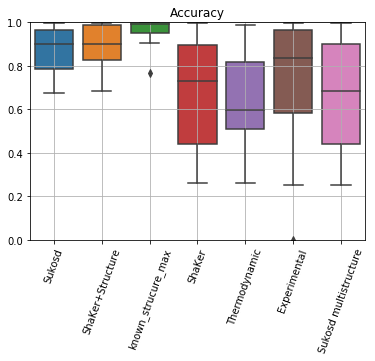

In [7]:
import pandas
import numpy as np
index= ['Sukosd',"ShaKer+Structure", "known_strucure_max","ShaKer","Thermodynamic",'Experimental',"Sukosd multistructure"]


data = map(lambda x: [x[k] for k in keys] ,[acc_suko, acc_shaker,acc_thoretical_best,acc_shaker_plain, acc_noshape, acc_real,acc_suko_predicted])

#import notebook_helper as nbh
#nbh.boxplotDraw(data,index,"i am the fig title","","FUCKOFF")

import seaborn as sns
plt.xticks(rotation=70)
g=sns.boxplot(data=pandas.DataFrame(data, index=index).T)
plt.title("Accuracy")
g.set(ylim=(0, 1))
plt.grid()



In [8]:

map(lambda x:x.append(np.mean(x)),data)
df = pandas.DataFrame(data, columns=keys+['mean'], index=index).T

print df.to_latex()

\begin{tabular}{lrrrrrrr}
\toprule
{} &    Sukosd &  ShaKer+Structure &  known\_strucure\_max &    ShaKer &  Thermodynamic &  Experimental &  Sukosd multistructure \\
\midrule
TRP5       &  0.889256 &          0.900539 &            0.958850 &  0.898664 &       0.838098 &      0.821419 &               0.902779 \\
5srRNA     &  0.905238 &          0.924478 &            0.997156 &  0.258704 &       0.260634 &      0.252744 &               0.253065 \\
GLYCFN     &  0.979977 &          0.983376 &            0.999256 &  0.391439 &       0.565605 &      0.000000 &               0.370368 \\
RNAsep     &  0.762381 &          0.682258 &            0.766092 &  0.682743 &       0.530544 &      0.676623 &               0.681566 \\
adenin     &  0.996944 &          0.989105 &            0.999496 &  0.989068 &       0.871697 &      0.981553 &               0.989032 \\
Z-CIDGMP-1 &  0.776530 &          0.822367 &            0.987850 &  0.746126 &       0.727020 &      0.759976 &               0.762059

In [9]:
from tabulate import tabulate 
print tabulate(df, headers="keys", tablefmt="orgtbl")

|            |   Sukosd |   ShaKer+Structure |   known_strucure_max |   ShaKer |   Thermodynamic |   Experimental |   Sukosd multistructure |
|------------+----------+--------------------+----------------------+----------+-----------------+----------------+-------------------------|
| TRP5       | 0.889256 |           0.900539 |             0.95885  | 0.898664 |        0.838098 |       0.821419 |                0.902779 |
| 5srRNA     | 0.905238 |           0.924478 |             0.997156 | 0.258704 |        0.260634 |       0.252744 |                0.253065 |
| GLYCFN     | 0.979977 |           0.983376 |             0.999256 | 0.391439 |        0.565605 |       0        |                0.370368 |
| RNAsep     | 0.762381 |           0.682258 |             0.766092 | 0.682743 |        0.530544 |       0.676623 |                0.681566 |
| adenin     | 0.996944 |           0.989105 |             0.999496 | 0.989068 |        0.871697 |       0.981553 |                0.989032 |
| Z-CI

---